In [ ]:
%%sql


Fetch average queue times by week using panda.  Imports first.

In [145]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf


import tensorflow as tf


Establish connection to cedar point database for sqllite

In [ ]:
conn = sqlite3.connect('../../../cp.db')

Establish connection to postgres in aws

In [147]:
import psycopg2

def get_db_connection():
    try:
        conn = psycopg2.connect(
            host='cp-ai.cbsscwgeqp5j.us-east-2.rds.amazonaws.com',
            port=5432,
            database='postgres',
            user='postgres',
            password='CedarP0int'
        )
        return conn
    except psycopg2.Error as e:
        print(f"Error connecting to PostgreSQL database: {e}")
        return None

# Example usage:
conn = get_db_connection()


In [148]:
df = pd.read_sql("SELECT * FROM crowd_levels", conn)
conn.close()

C:\Users\rober\AppData\Local\Temp\ipykernel_53620\662286218.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM crowd_levels", conn)


In [149]:
df.head()               # Preview first few rows
df["crowd_level"].mean()  # Compute average wait time

19.290514421647337

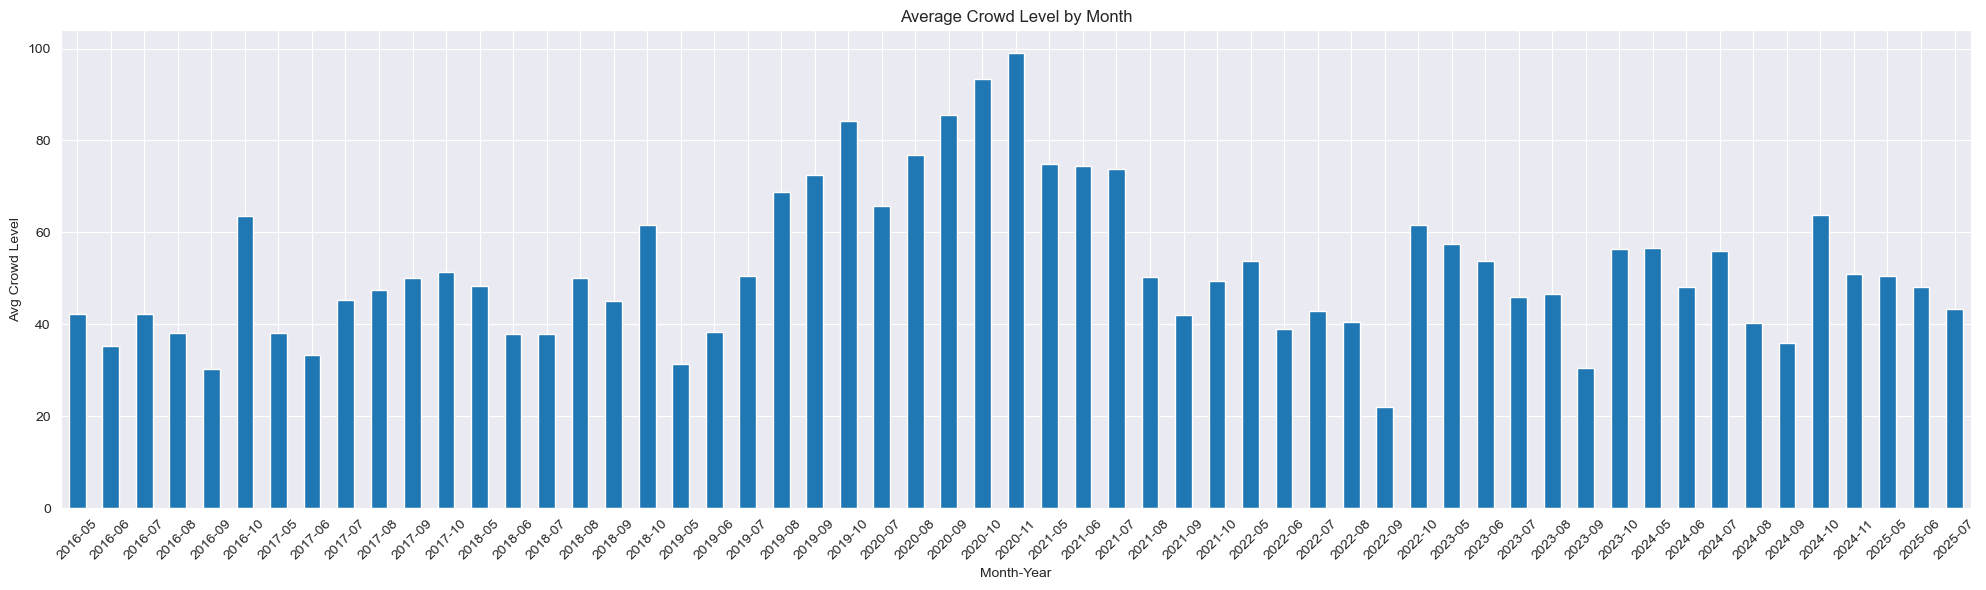

In [150]:
df["year_month"] = df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)
df["year_week"] = df["year"].astype(str) + "-" + df["season_week"].astype(str).str.zfill(2)

monthly_avg = df[df["is_open"] == 'Y'].groupby("year_month")["crowd_level"].mean()
monthly_avg = monthly_avg.sort_index()  # This sorts by year_month
monthly_avg.plot(kind="bar", title="Average Crowd Level by Month", figsize=(20, 6))
plt.xlabel("Month-Year")
plt.ylabel("Avg Crowd Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [151]:

print(df.columns)

Index(['date', 'crowd_level', 'year', 'day_of_week', 'is_open',
       'forecast_temp', 'actual_temp', 'forecast_wind', 'actual_wind',
       'forecast_rain', 'actual_rain', 'special_day_halloweekends',
       'special_day_military_days', 'special_day_light_up_the_point',
       'special_day_coaster_mania', 'special_day_opening_day',
       'special_day_boardwalk_nights', 'special_day_fathers_day',
       'special_day_mothers_day', 'special_day_fourth_of_july',
       'special_day_memorial_day', 'special_day_labor_day',
       'special_day_last_day_of_year', 'covid_19_day', 'reload_row', 'month',
       'cedar_point_week', 'school_day', 'year_month', 'year_week'],
      dtype='object')


Below grabs the features of interest and removes one that has a null for the actual temp.

In [231]:
park_features = df[(df['is_open'] == 'Y') &(df['covid_19_day'] == 'N') & df["actual_temp"].notnull() & df["actual_rain"].notnull()][[
    "day_of_week",
    "actual_temp",
    "actual_rain",
    "month",
    "season_week",
    "school_season",
    "hallowweekend",
    "coaster_mania",
    "opening_day",
    "fathers_day",
    "mothers_day",
    "fourth_of_july",
    "crowd_level"
]]
crowd_levels = park_features["crowd_level"]

# 0-300 = 1-22,  to 600 23-47,  to 900 48-72, 73 and above for group 4
 #   -- 3 groups.  0-400 1:30.  401-800 31:64  801+: 65 +

def categorize_crowd_level_4_group(pct):
    if pct < 23:
        return 0  # Low
    elif pct < 48:
        return 1  # Medium
    elif pct < 73:
        return 2  # High
    else:
        return 3  # Very High

def categorize_crowd_level_3_group(pct):
    if pct < 31:
        return 0  # Low
    elif pct < 76:
        return 1  # Medium
    else:
        return 2  # High


crowd_categories = crowd_levels.apply(categorize_crowd_level_3_group).rename("crowd_category")
crowd_categories.head()



31    0
32    1
33    2
34    0
35    0
Name: crowd_category, dtype: int64

Add properties for temperature range groups and rain groups.  Will be as follows:

Range (inches)	Label	Notes

0	None	No rain

0.01 – 0.1	Light	Barely noticeable drizzle

0.1 – 0.3	Moderate	Noticeable but tolerable rain

0.3 – 0.6	Heavy	Rain gear required; ride impacts begin

0.6 – 1.0	Very Heavy	Likely to deter attendance

> 1.0	Downpour	Strong disincentive to visit


Range	Label

< 50°F	Cold

50–59°F	Chilly

60–69°F	Mild

70–79°F	Warm80–89°F	Hot

90°F and above	Very Hot

In [232]:
def categorize_rain_categories(rain_amount):
    if (rain_amount == 0):
        return "None"
    elif (rain_amount < 0.1):
        return "Light"
    elif (rain_amount < 0.3):
        return "Moderate"
    elif (rain_amount < 0.6):
        return "Heavy"
    elif (rain_amount < 1.0):
        return "Very Heavy"
    else:
        return "Downpour"

actual_rain = park_features["actual_rain"]

rain_categories = actual_rain.apply(categorize_rain_categories).rename("rain_category")
rain_categories.head()

31       Light
32       Light
33    Moderate
34       Light
35        None
Name: rain_category, dtype: object

In [233]:

def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

def categorize_temp_categories(actual_temp):
    actual_temp = celsius_to_fahrenheit(actual_temp)
    if (actual_temp < 50):
        return "Cold"
    elif (actual_temp < 60):
        return "Chilly"
    elif (actual_temp < 70):
        return "Mild"
    elif (actual_temp < 80):
        return "Warm"
    elif (actual_temp < 90):
        return "Hot"
    else:
        return "VeryHot"

actual_temp = park_features["actual_temp"]
temp_categories = actual_temp.apply(categorize_temp_categories).rename("temp_categories")
temp_categories.head()



31    Warm
32    Warm
33    Warm
34    Warm
35    Mild
Name: temp_categories, dtype: object

In [234]:
def cedar_point_season_calculator(season_week):
    if (season_week < 4):
        return "Opening"
    elif (season_week < 7):
        return "PreSummer"
    elif (season_week < 15):
        return "Summer"
    elif (season_week < 20):
        return "BeginningOfSchool"
    else:
        return "Hallowweekends"

season_week = park_features["season_week"]
cedar_point_season = season_week.apply(cedar_point_season_calculator).rename("cedar_point_season")
cedar_point_season.head(100)

31        Hallowweekends
32        Hallowweekends
33        Hallowweekends
34        Hallowweekends
35        Hallowweekends
             ...        
602               Summer
629    BeginningOfSchool
630    BeginningOfSchool
631    BeginningOfSchool
633    BeginningOfSchool
Name: cedar_point_season, Length: 100, dtype: object

Add the newly created categories for temperature and rain to the park features data frame and remove the original numeric values for temperature and rain.

In [235]:
park_features["temp_categories"] = temp_categories
park_features["rain_category"] = rain_categories
park_features["cedar_point_season"] = cedar_point_season
park_features = park_features.drop(["actual_temp", "actual_rain","crowd_level","month","season_week","hallowweekend","school_season"], axis=1)
park_features.head()

,day_of_week,special_day_coaster_mania,special_day_opening_day,special_day_fathers_day,special_day_mothers_day,special_day_fourth_of_july,temp_categories,rain_category,cedar_point_season
31,Sunday,N,N,N,N,N,Warm,Light,Hallowweekends
32,Friday,N,N,N,N,N,Warm,Light,Hallowweekends
33,Saturday,N,N,N,N,N,Warm,Moderate,Hallowweekends
34,Sunday,N,N,N,N,N,Warm,Light,Hallowweekends
35,Friday,N,N,N,N,N,Mild,None,Hallowweekends


The month and day_of_week values and other categories must be "one-hot encoded" in order to avoid misinterpretations.  If it is not, the model may try to establish relationships between the different items.  This is not 100% ideal since there are to some degree relationships between them (May leads into June and may share crowd levels but does not lead into August, Friday crowds may lead into Saturday but Mondays would not lead to Thursdays).  To do this more sophisticated aspect of things there is some type of sine/cosine transformation we can do at a later point.

The following produces matrixes where each item in the matrix is an array of 7 items (for day_of_week) or 12 items (for month) where only 1 of these is set to true depending on what value that column in the matrix is mapped to.

In addition y/n values are converted to 0/1 values.


In [236]:
# Convert Y/N to 1/0
park_features['coaster_mania'] = (park_features['coaster_mania'] == 'Y').astype(int)
park_features['opening_day'] = (park_features['opening_day'] == 'Y').astype(int)
park_features['fathers_day'] = (park_features['fathers_day'] == 'Y').astype(int)
park_features['mothers_day'] = (park_features['mothers_day'] == 'Y').astype(int)
park_features['fourth_of_july'] = (park_features['fourth_of_july'] == 'Y').astype(int)


# Use get_dummies with prefix dictionary
park_features = pd.get_dummies(
    park_features,
    columns=['day_of_week', 'cedar_point_season', 'temp_categories', 'rain_category'],
    prefix={
        'day_of_week': 'day',
        'cedar_point_season': 'cedar_point_season',
        'temp_categories': 'temperature',
        'rain_category': 'rain'
    }
)

park_features.head()


,special_day_coaster_mania,special_day_opening_day,special_day_fathers_day,special_day_mothers_day,special_day_fourth_of_july,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,...,temperature_Hot,temperature_Mild,temperature_VeryHot,temperature_Warm,rain_Downpour,rain_Heavy,rain_Light,rain_Moderate,rain_None,rain_Very Heavy
31,0,0,0,0,0,False,False,False,True,False,...,False,False,False,True,False,False,True,False,False,False
32,0,0,0,0,0,True,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
33,0,0,0,0,0,False,False,True,False,False,...,False,False,False,True,False,False,False,True,False,False
34,0,0,0,0,0,False,False,False,True,False,...,False,False,False,True,False,False,True,False,False,False
35,0,0,0,0,0,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False


Create test split.  This will result in 4 matrixes.  X_train will have all the park_features and y_train will have the corresponding crowd_level (same index on each).  A certain percent of the records will NOT be included in this and used for verification.  This is the X_test and y_test values.  The percent that is not placed in the "real" but included in these is a percent based on test_size.  random_state is used to ensure that the same ones for the given percent are picked every time.

In [237]:
import sklearn.model_selection
import numpy as np
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(park_features, crowd_categories, test_size=0.2, random_state=42)

# Convert boolean columns to int32
X_train = X_train.astype('int32')
X_test = X_test.astype('int32')

# Convert y_train to numpy array if it isn't already
y_train = np.array(y_train)
y_test = np.array(y_test)


In [238]:
X_train.head()

,special_day_coaster_mania,special_day_opening_day,special_day_fathers_day,special_day_mothers_day,special_day_fourth_of_july,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,...,temperature_Hot,temperature_Mild,temperature_VeryHot,temperature_Warm,rain_Downpour,rain_Heavy,rain_Light,rain_Moderate,rain_None,rain_Very Heavy
2216,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
1159,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1684,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1690,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


Import the tensorflow library to begin working with an actual model

In [239]:
import tensorflow as tf


n_features = X_train.shape[1]  # Get number of features from your storage

# Method 1: Using Input layer
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_features,)),  # Correct way to specify input
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(4)
])


In [240]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

crowd_categories.unique()


array([0, 1, 2], dtype=int64)

In [241]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3246 - loss: 1.3619 - val_accuracy: 0.4456 - val_loss: 1.2438
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4562 - loss: 1.2152 - val_accuracy: 0.4870 - val_loss: 1.1418
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4771 - loss: 1.1286 - val_accuracy: 0.4870 - val_loss: 1.0745
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4827 - loss: 1.0594 - val_accuracy: 0.4870 - val_loss: 1.0428
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4852 - loss: 1.0217 - val_accuracy: 0.4974 - val_loss: 1.0209
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4885 - loss: 1.0147 - val_accuracy: 0.4922 - val_loss: 0.9986
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5121 - loss: 0.9767 - val_accuracy: 0.5078 - val_loss: 0.9800
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5391 - loss: 0.9509 - val_accuracy: 0.5285 - val_loss:

In [242]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.5843 - loss: 0.9056
Test Accuracy: 0.59


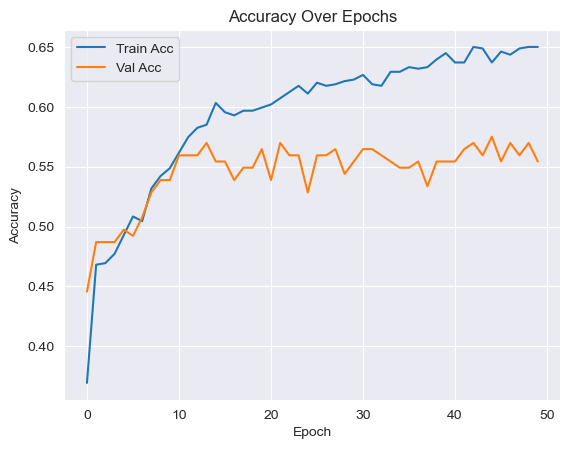

In [243]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [244]:
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

import pandas as pd
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
print(comparison_df.head(20))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
    Actual  Predicted
0        1          1
1        1          0
2        0          0
3        0          1
4        2          2
5        1          1
6        1          0
7        2          2
8        1          1
9        1          1
10       0          1
11       0          1
12       0          0
13       2          2
14       2          0
15       1          1
16       1          1
17       1          0
18       0          1
19       1          0


Instead of a neural network, try a simpler standard logistic regression model

In [245]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(
    multi_class='multinomial',  # for multiple classes
    max_iter=1000,             # increase iterations if needed
    random_state=42            # for reproducibility
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.66      0.43      0.52        93
           1       0.48      0.65      0.55        95
           2       0.63      0.60      0.62        53

    accuracy                           0.56       241
   macro avg       0.59      0.56      0.56       241
weighted avg       0.58      0.56      0.55       241



C:\Users\rober\miniconda3\envs\CedarPointMLModel\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Show Feature Importance


Top 15 Most Important Features:
                                 feature  importance
7                           day_Saturday    1.096158
12  cedar_point_season_BeginningOfSchool    0.566108
9                           day_Thursday    0.516700
21                   temperature_VeryHot    0.449043
3                special_day_mothers_day    0.444709
2                special_day_fathers_day    0.394434
4             special_day_fourth_of_july    0.360297
16             cedar_point_season_Summer    0.349981
0              special_day_coaster_mania    0.335828
5                             day_Friday    0.328371
27                             rain_None    0.317424
13     cedar_point_season_Hallowweekends    0.299784
23                         rain_Downpour    0.276885
11                         day_Wednesday    0.266326
17                    temperature_Chilly    0.262950


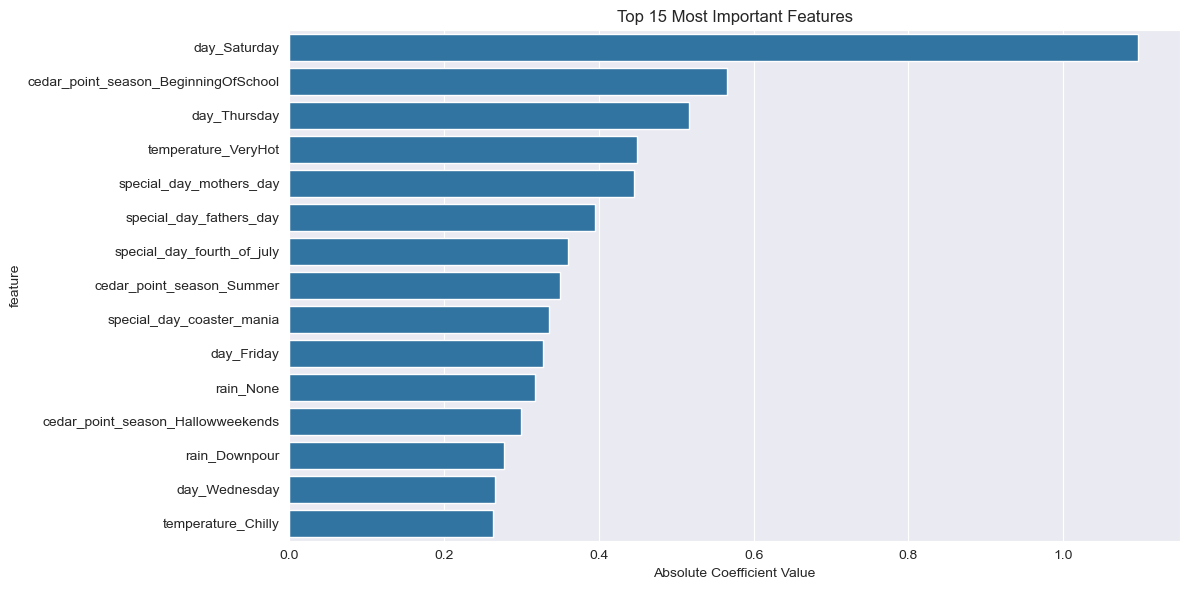

In [246]:
import pandas as pd
import numpy as np
import seaborn as sns

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(model.coef_).mean(axis=0)
})

# Sort and display top features
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()


Introduce polynomial features to see if it helps.

In [247]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial and interaction features
# degree=2 means it will create:
# - original features
# - squared terms (X²)
# - interaction terms (X1*X2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train)

# Create new feature names for interpretation
feature_names = poly.get_feature_names_out(X_train.columns)

# Create new logistic regression with the polynomial features
model_poly = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
model_poly.fit(X_poly, y_train)

# Transform test storage the same way
X_test_poly = poly.transform(X_test)

# Make predictions
y_pred_poly = model_poly.predict(X_test_poly)

# Print performance metrics
print("\nClassification Report with Polynomial Features:")
print(classification_report(y_test, y_pred_poly))



Classification Report with Polynomial Features:
              precision    recall  f1-score   support

           0       0.68      0.52      0.59        93
           1       0.52      0.62      0.56        95
           2       0.52      0.55      0.53        53

    accuracy                           0.56       241
   macro avg       0.57      0.56      0.56       241
weighted avg       0.58      0.56      0.57       241



C:\Users\rober\miniconda3\envs\CedarPointMLModel\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


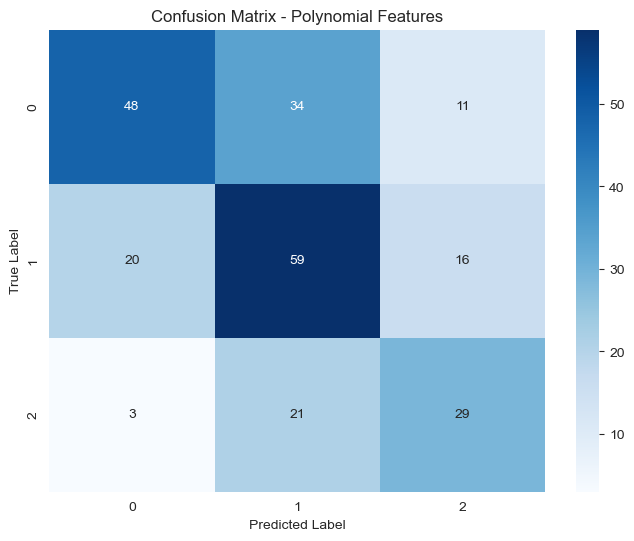


Top 15 Most Important Features:
                                               feature  importance
280              day_Tuesday cedar_point_season_Summer    0.639255
440                     temperature_Warm rain_Moderate    0.573881
216  day_Saturday cedar_point_season_BeginningOfSchool    0.559124
211                                     day_Saturday^2    0.547359
7                                         day_Saturday    0.547359
230                         day_Saturday rain_Moderate    0.538855
298            day_Wednesday cedar_point_season_Summer    0.511391
322  cedar_point_season_BeginningOfSchool rain_Down...    0.489595
175               day_Friday cedar_point_season_Summer    0.482059
276   day_Tuesday cedar_point_season_BeginningOfSchool    0.480833
220             day_Saturday cedar_point_season_Summer    0.473364
288                             day_Tuesday rain_Heavy    0.459602
173              day_Friday cedar_point_season_Opening    0.459479
224                      day_

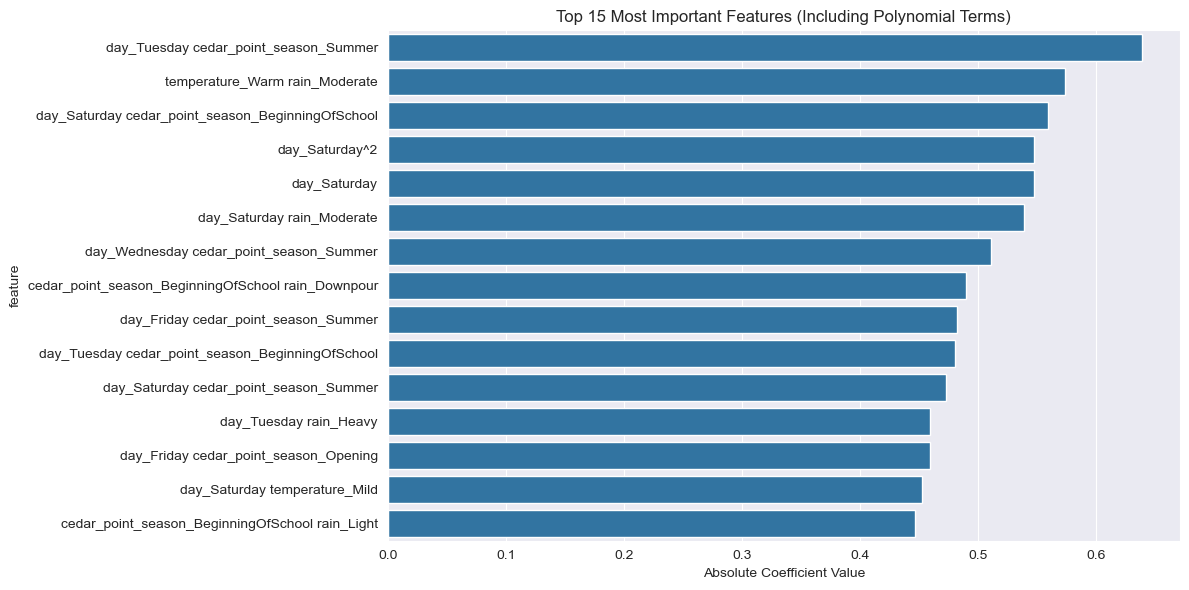

In [248]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_poly)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Polynomial Features')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get feature names and importance
feature_names = poly.get_feature_names_out(X_train.columns)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(model_poly.coef_).mean(axis=0)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Show top 15 most important features
print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))

# Visualize top features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features (Including Polynomial Terms)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()


Try a decision tree.


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.51      0.53        93
           1       0.48      0.57      0.52        95
           2       0.67      0.53      0.59        53

    accuracy                           0.54       241
   macro avg       0.56      0.53      0.54       241
weighted avg       0.55      0.54      0.54       241



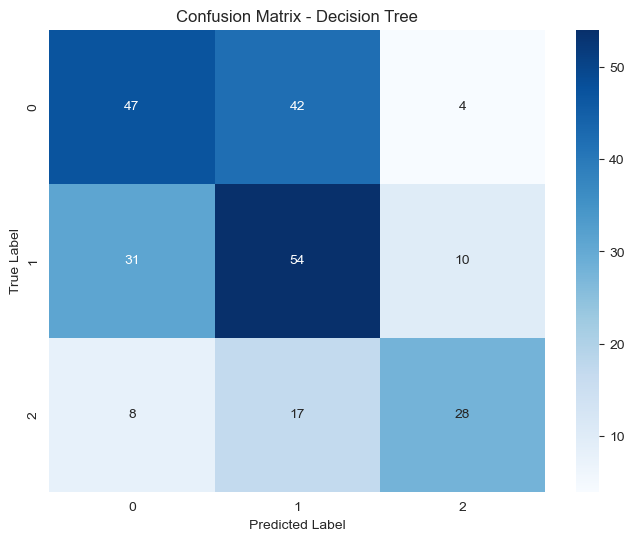


Top 10 Most Important Features:
                                 feature  importance
7                           day_Saturday    0.422173
12  cedar_point_season_BeginningOfSchool    0.165214
13     cedar_point_season_Hallowweekends    0.043239
27                             rain_None    0.043162
22                      temperature_Warm    0.042206
10                           day_Tuesday    0.042067
5                             day_Friday    0.035746
16             cedar_point_season_Summer    0.035484
24                            rain_Heavy    0.035006
9                           day_Thursday    0.027597


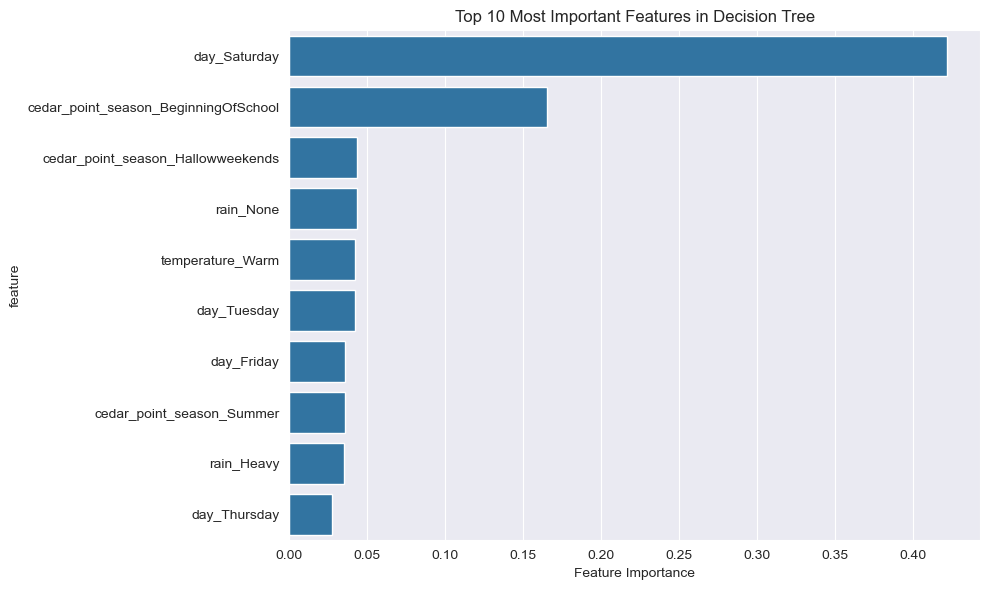

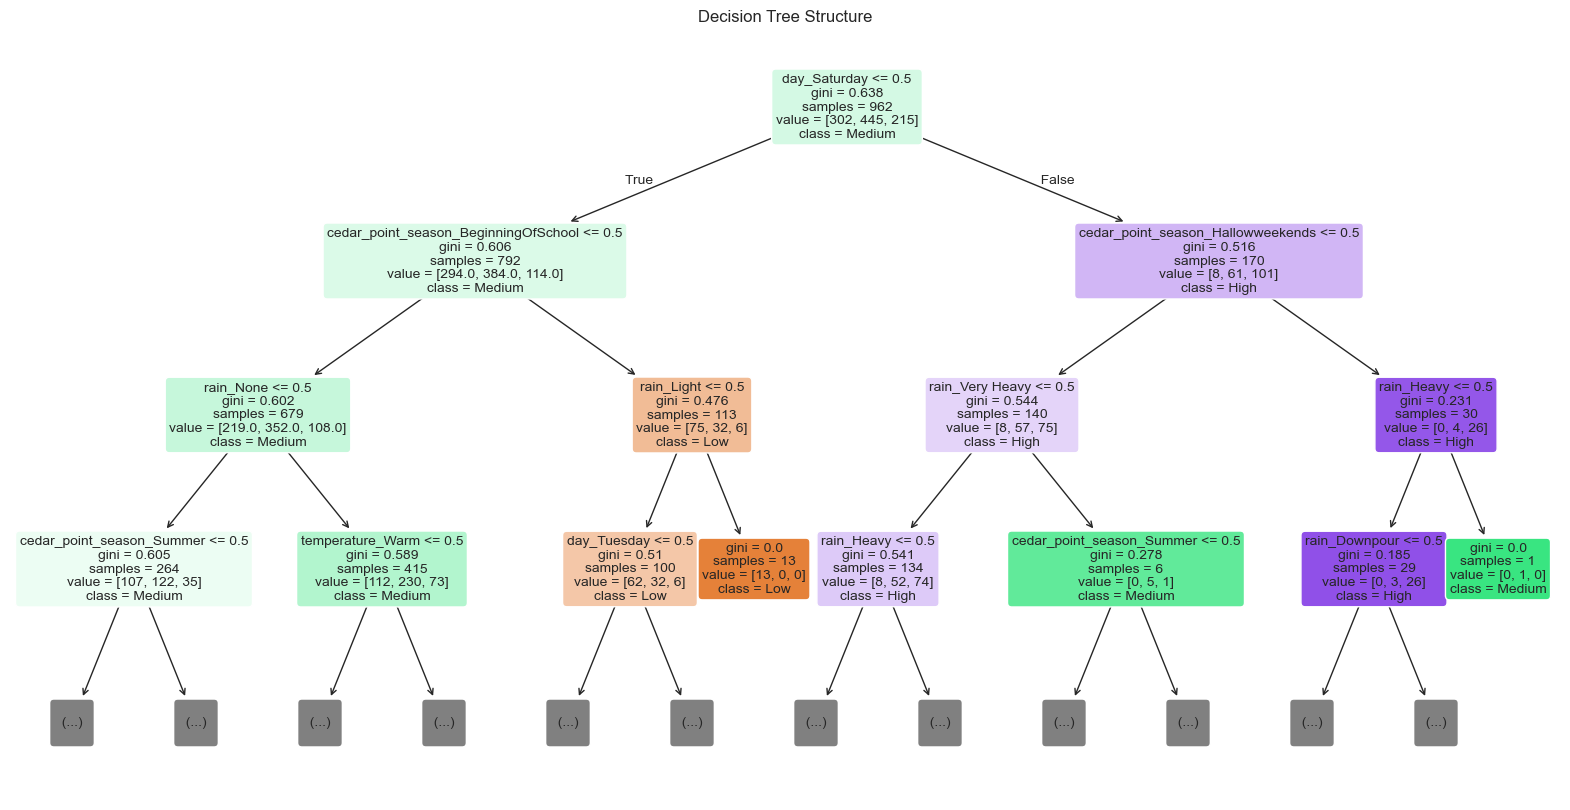

In [249]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Create and train the decision tree
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=5  # Limit depth to make it more interpretable
)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Print performance metrics
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Show top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features in Decision Tree')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Visualize the decision tree (limited to first few levels for clarity)
plt.figure(figsize=(20,10))
plot_tree(dt_model,
          feature_names=X_train.columns,
          class_names=['Low', 'Medium', 'High', 'Very High'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)  # Show only first 3 levels
plt.title('Decision Tree Structure')
plt.show()


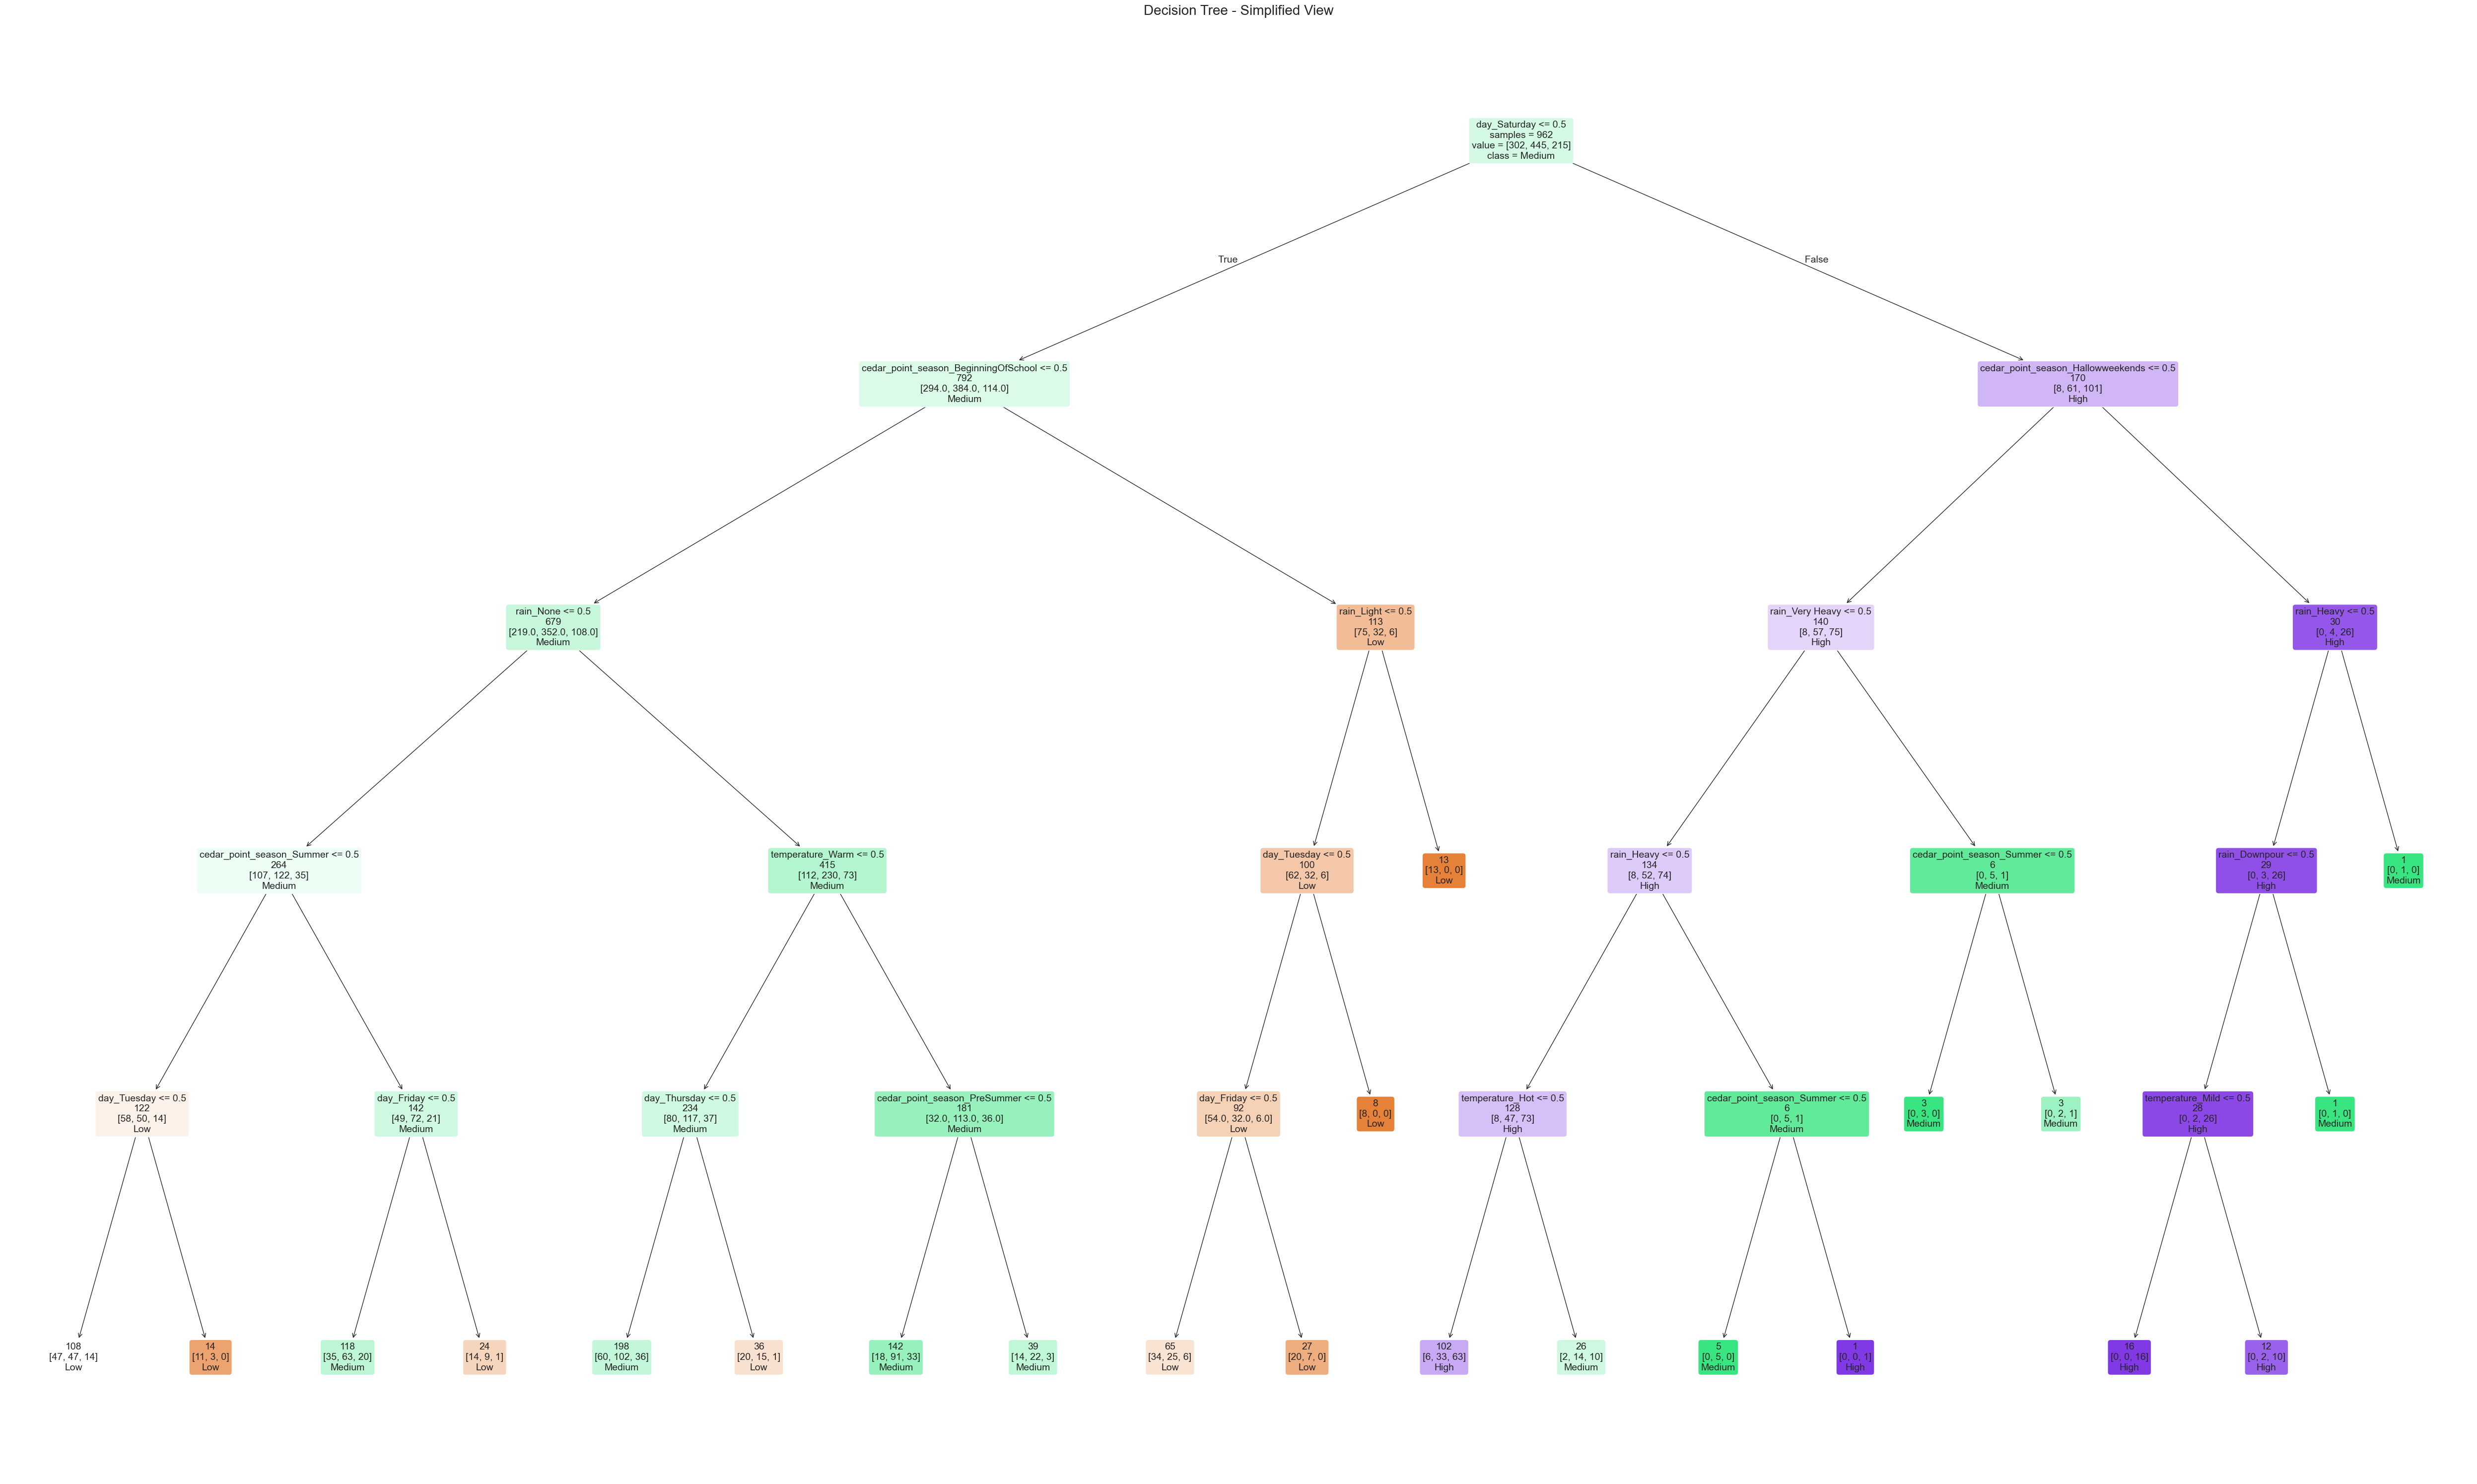

In [250]:
plt.figure(figsize=(50, 30), facecolor='white')  # Much larger figure size
plot_tree(dt_model,
          feature_names=X_train.columns,
          class_names=['Low', 'Medium', 'High', 'Very High'],
          filled=True,
          rounded=True,
          fontsize=14,  # Larger font size
          max_depth=None,
          impurity=False,
          proportion=False,
          precision=2,
          node_ids=False,
          label='root')
plt.title('Decision Tree - Simplified View', fontsize=20)
plt.tight_layout()  # This helps ensure everything fits
plt.show()


Cross-validation scores (RMSE):
Individual fold scores: [0.69113634 0.64557675 0.65794574 0.63568951 0.67493886]
Mean RMSE: 0.66 (+/- 0.04)

Out-of-bag score: 0.152

Test set metrics:
MAE: 0.55
RMSE: 0.70
Exact matches: 52.3%
Predictions within one level: 97.1%


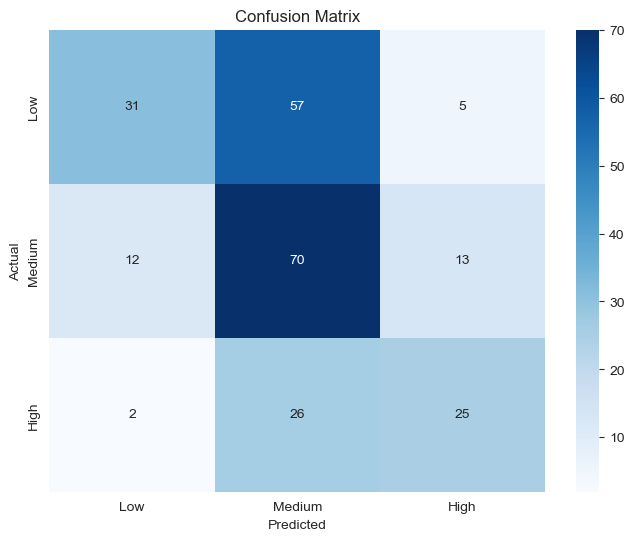


Prediction Distribution:
Predicted   0    1   2  All
Actual                     
0          31   57   5   93
1          12   70  13   95
2           2   26  25   53
All        45  153  43  241


In [253]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Create and train the random forest model
rf_model = RandomForestRegressor(
    n_estimators=100,  # number of trees in the forest
    max_depth=None,    # maximum depth of the trees
    random_state=42,    # for reproducibility
    oob_score=True
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Convert MSE to RMSE (Root Mean Squared Error)
rmse_scores = np.sqrt(-cv_scores)

print("Cross-validation scores (RMSE):")
print(f"Individual fold scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std() * 2:.2f})")

# Now fit the model on the full training storage for final evaluation
rf_model.fit(X_train, y_train)

# Get the out-of-bag score (if enabled)
print(f"\nOut-of-bag score: {rf_model.oob_score_:.3f}")

# Make predictions on test set
rf_preds = rf_model.predict(X_test)

# Calculate final test set metrics
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(rf_mse)

print(f"\nTest set metrics:")
print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")

# Make predictions on test storage
test_preds = rf_model.predict(X_test)

# Round predictions to nearest integer for classification
test_preds_rounded = np.round(test_preds).astype(int)

# Calculate accuracy
accuracy = (test_preds_rounded == y_test).mean() * 100
print(f"Exact matches: {accuracy:.1f}%")

# Calculate percentage within one level
within_one = (np.abs(test_preds_rounded - y_test) <= 1).mean() * 100
print(f"Predictions within one level: {within_one:.1f}%")

# Show confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_preds_rounded)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Show distribution of predictions vs actual values
print("\nPrediction Distribution:")
print(pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(test_preds_rounded, name='Predicted'),
    margins=True
))


Do gradient boost


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.45      0.54        93
           1       0.49      0.68      0.57        95
           2       0.62      0.53      0.57        53

    accuracy                           0.56       241
   macro avg       0.59      0.55      0.56       241
weighted avg       0.58      0.56      0.56       241


Overall Accuracy: 56.02%

Detailed Accuracy by Class:
Low class accuracy: 45.16%
Medium class accuracy: 68.42%
High class accuracy: 52.83%

Predictions within one level: 96.27%


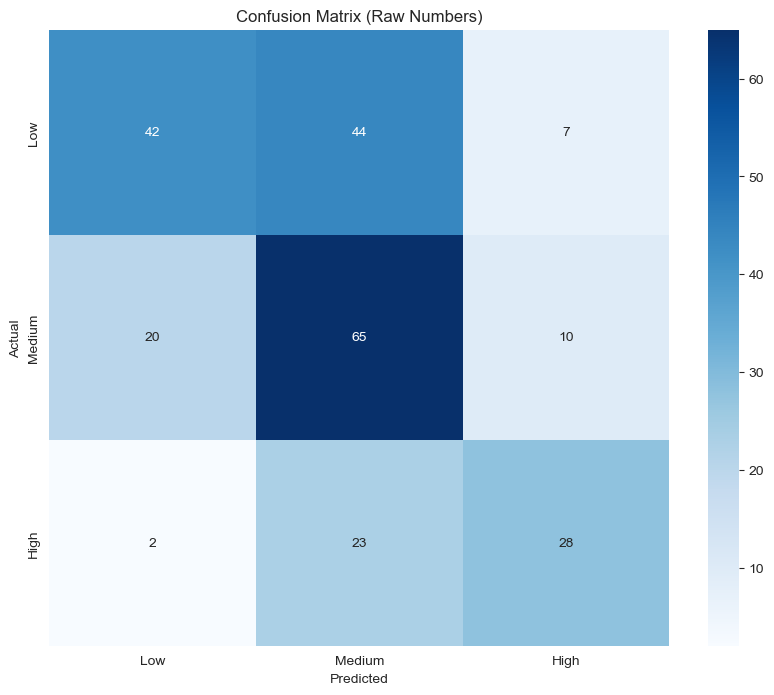

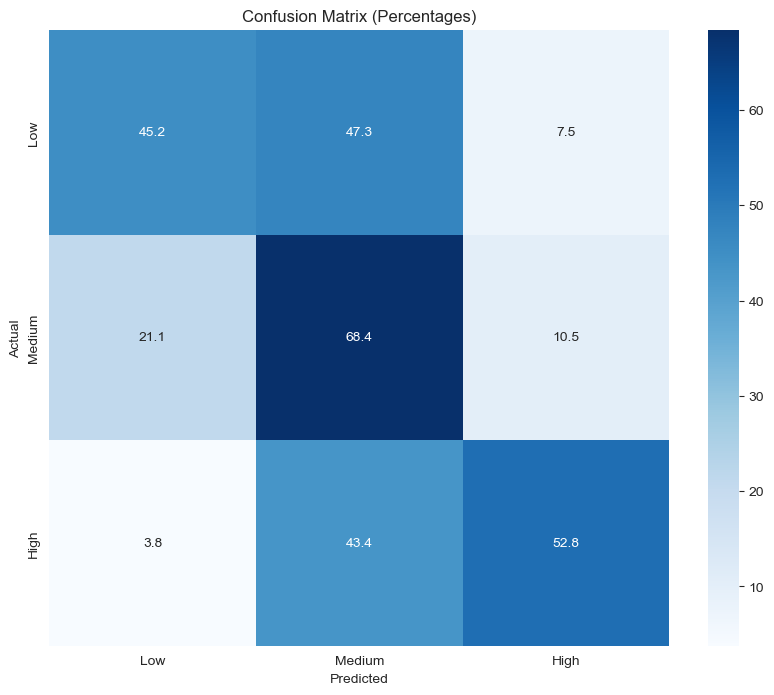

In [255]:
# Option 1: Using scikit-learn's GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Option 2: Using XGBoost (generally performs better)
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train and evaluate (using XGBoost as example)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Print performance metrics
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))

# Calculate overall accuracy
accuracy = (xgb_preds == y_test).mean() * 100
print(f"\nOverall Accuracy: {accuracy:.2f}%")

# Calculate accuracy by class and show more detailed metrics
print("\nDetailed Accuracy by Class:")
cm = confusion_matrix(y_test, xgb_preds)
cm_df = pd.DataFrame(
    cm,
    index=['Actual Low', 'Actual Medium', 'Actual High'],
    columns=['Pred Low', 'Pred Medium', 'Pred High']
)

# Calculate class-specific accuracies
class_accuracy = np.diag(cm) / np.sum(cm, axis=1) * 100
for i, class_name in enumerate(['Low', 'Medium', 'High']):
    print(f"{class_name} class accuracy: {class_accuracy[i]:.2f}%")

# Calculate predictions within one level
within_one = (np.abs(xgb_preds - y_test) <= 1).mean() * 100
print(f"\nPredictions within one level: {within_one:.2f}%")

# Show confusion matrix with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix (Raw Numbers)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Show confusion matrix with percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix (Percentages)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
